In [ ]:
!pip install aif360==0.3.0 
!pip install BlackBoxAuditing
!pip install tensorflow==1.12.0
import matplotlib.pyplot as plt 

import random
random.seed(6)

import sys
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf

from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.inprocessing.meta_fair_classifier import MetaFairClassifier
import BlackBoxAuditing
from aif360.algorithms.preprocessing import Reweighing
from aif360.datasets import CompasDataset, AdultDataset, StandardDataset, BankDataset, GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.postprocessing import EqOddsPostprocessing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult


from aif360.algorithms.inprocessing import GerryFairClassifier
from aif360.algorithms.inprocessing import PrejudiceRemover

from sklearn.preprocessing import MinMaxScaler
from aif360.metrics import BinaryLabelDatasetMetric

from aif360.algorithms.postprocessing.reject_option_classification import RejectOptionClassification
import seaborn as sns

%matplotlib inline

ERROR: Could not find a version that satisfies the requirement tensorflow==1.12.0 (from versions: 1.13.0rc1, 1.13.0rc2, 1.13.1, 1.13.2, 1.14.0rc0, 1.14.0rc1, 1.14.0, 1.15.0rc0, 1.15.0rc1, 1.15.0rc2, 1.15.0rc3, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0a0, 2.0.0b0, 2.0.0b1, 2.0.0rc0, 2.0.0rc1, 2.0.0rc2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0rc0, 2.1.0rc1, 2.1.0rc2, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.2.0rc0, 2.2.0rc1, 2.2.0rc2, 2.2.0rc3, 2.2.0rc4, 2.2.0, 2.2.1, 2.2.2, 2.3.0rc0, 2.3.0rc1, 2.3.0rc2, 2.3.0, 2.3.1, 2.3.2, 2.4.0rc0, 2.4.0rc1, 2.4.0rc2, 2.4.0rc3, 2.4.0rc4, 2.4.0, 2.4.1)
ERROR: No matching distribution found for tensorflow==1.12.0


# Problem 2
### **Load and split data into train, validation and test sets** 

### Read in the data

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
!wget	https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names

--2021-03-07 00:41:47--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data.2’

adult.data.2        100%[===================>]   3.79M  7.36MB/s    in 0.5s    

2021-03-07 00:41:48 (7.36 MB/s) - ‘adult.data.2’ saved [3974305/3974305]

--2021-03-07 00:41:48--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2003153 (1.9M) [application/x-httpd-php]
Saving to: ‘adult.test.2’

adult.test.2        100%[===================>]   1.91M  4.24MB/s    in 0.5s    

In [ ]:
!cp adult.data /usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult/
!cp adult.test /usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult/
!cp adult.names /usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult/

In [ ]:
adult_dataset = AdultDataset(protected_attribute_names=['sex'], 
                             privileged_classes=[['Male']], 
                             features_to_drop=['fnlwgt', 'race'])

In [ ]:
# Split original dataset into train & test set
train_data, test_data = adult_dataset.split([0.7], shuffle=True, seed=10)

# Split test set into test & validation set
val_data, test_data = test_data.split([0.33], shuffle=True)

# Convert to dataframes
train_df, _ = train_data.convert_to_dataframe()
val_df, _ = val_data.convert_to_dataframe()
test_df, _ = test_data.convert_to_dataframe()

# Check shape
print("Train set: ", train_df.shape)
print("Val set: ", val_df.shape)
print("Test set: ", test_df.shape)

Train set:  (31655, 98)
Val set:  (4477, 98)
Test set:  (9090, 98)


In [ ]:
# Analyze protected attribute in train dataset
print("Sex: 1 = Male, 0 = Female")
print(train_df['sex'].value_counts())

# Analyze income distribution in privileged class (men)
print('\nMale income distribution: 1 = >$50k, 0 = <$50k')
print(train_df[train_df['sex'] == 1]['income-per-year'].value_counts())
print("High-to-low income ratio = {:.2f}x".format(6655 / 14640))

# Analyze income distirbution in unprivileged class (women)
print('\nFemale income distribution: 1 = >$50k, 0 = <$50k')
print(train_df[train_df['sex'] == 0]['income-per-year'].value_counts())
print("High-to-low income ratio = {:.2f}x".format(1172 / 9188))

Sex: 1 = Male, 0 = Female
1.0    21295
0.0    10360
Name: sex, dtype: int64

Male income distribution: 1 = >$50k, 0 = <$50k
0.0    14640
1.0     6655
Name: income-per-year, dtype: int64
High-to-low income ratio = 0.45x

Female income distribution: 1 = >$50k, 0 = <$50k
0.0    9188
1.0    1172
Name: income-per-year, dtype: int64
High-to-low income ratio = 0.13x


# Problem 2, Part (a) 
### **Train a baseline Logistic Regression (LR) & Random Forest (RF) model and report metrics**

In [ ]:
# Split features & labels
X_train = train_df.drop('income-per-year', axis=1)
y_train = train_df['income-per-year']

X_val = val_df.drop('income-per-year', axis=1)
y_val = val_df['income-per-year']

X_test = test_df.drop('income-per-year', axis=1)
y_test = test_df['income-per-year']

# Fit scaler & transform features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [ ]:
def compute_evaluation_metrics(orig_test_dataset, predictions_df):
  """Input: original dataset with ground truth labels as standard dataset and dataframe with predicted labels
  Returns: dict with evaluation metrics"""

  # Convert predictions df to standard dataset
  preds_std_dataset = StandardDataset(predictions_df, label_name='income-per-year', favorable_classes=[1], 
                                 protected_attribute_names=['sex'], privileged_classes=[[1.0]])
  
  privileged_groups = [{'sex': 1.0}]
  unprivileged_groups = [{'sex': 0.0}]

  # Convert datasets to binary label & classification metric objects
  preds_binary_metric = BinaryLabelDatasetMetric(preds_std_dataset, 
                                                 unprivileged_groups=unprivileged_groups, 
                                                 privileged_groups=privileged_groups)
  
  orig_vs_preds_metric = ClassificationMetric(orig_test_dataset, preds_std_dataset,
                                              unprivileged_groups=unprivileged_groups,
                                              privileged_groups=privileged_groups)
  
  # Compute evaluation metrics
  accuracy = orig_vs_preds_metric.accuracy()
  priv_accuracy = orig_vs_preds_metric.accuracy(privileged=True)
  unpriv_accuracy = orig_vs_preds_metric.accuracy(privileged=False)
  disp_impact = preds_binary_metric.disparate_impact()
  false_pos_dif = orig_vs_preds_metric.false_positive_rate_difference()

  return {"Accuracy": accuracy, "Privileged accuracy": priv_accuracy, "Unprivileged accuracy": unpriv_accuracy, "Disparate impact": disp_impact, "False positive rate difference": false_pos_dif}

### Baseline logistic regression model

In [ ]:
# Train baseline logistic regression model
lr_model = LogisticRegression(solver='liblinear')
lr_model.fit(X_train_scaled, y_train)

# Store predictions
lr_preds_df = test_df.copy()
lr_preds_df['income-per-year'] = lr_model.predict(X_test_scaled)

In [ ]:
# Compute evaluation metrics for baseline logistic regression model
untuned_lr_metrics = compute_evaluation_metrics(test_data, lr_preds_df)

print("Untuned logistic model metrics:\n")
for key, value in untuned_lr_metrics.items():
  print("{}: {:.5f}".format(key, value))

Untuned logistic model metrics:

Accuracy: 0.84378
Privileged accuracy: 0.80805
Unprivileged accuracy: 0.92003
Disparate impact: 0.31055
False positive rate difference: -0.07806


### Baseline random forest model

In [ ]:
# Train baseline random forest model
rand_forest = RandomForestClassifier()
rand_forest.fit(X_train_scaled, y_train)

# Store predictions
rf_preds_df = test_df.copy()
rf_preds_df['income-per-year'] = rand_forest.predict(X_test_scaled)

In [ ]:
# Compute evaluation metrics for baseline random forest model
untuned_rf_metrics = compute_evaluation_metrics(test_data, rf_preds_df)

print("Untuned random forest model metrics:\n")
for key, value in untuned_rf_metrics.items():
  print("{}: {:.5f}".format(key, value))

Untuned random forest model metrics:

Accuracy: 0.84048
Privileged accuracy: 0.80465
Unprivileged accuracy: 0.91693
Disparate impact: 0.33935
False positive rate difference: -0.08479


# Problem 2, Part (b)
### **Hyperparameter tuning of baseline LR and RF models**

In [ ]:
# Define function to plot pre- and post-tuning metrics boxplots
def plot_init_v_tuned_box(init_metrics, tuned_metrics, metric_name, ax):
  '''Creates a box-and-whisker plot comparing init_metrics to tuned_metrics on the given set of axes '''

  # Make some x values
  x_init = list(range(len(init_metrics)))
  x_tuned = [x + 0.35 for x in x_init]

  # Plot the metrics
  ax.boxplot([init_metrics, tuned_metrics], labels=['Initial Model', 'Tuned Model'])

  # Create labels, etc. 
  ax.set_ylabel(metric_name)
  ax.set_title(metric_name)

In [ ]:
# Define function to print pre- and post-tuning statistics
def print_statistics(pre_title, init_metrics, post_title, tuned_metrics):
  """Input: two dictionaries, keyed on evaluation metrics, representing values pre-intervention and post-intervention
  Prints median, mean, and standard deviation for each metric"""

  print(pre_title + ":")
  print("{blank: <33} {med: ^10} {mean: ^10} {std: ^10}".format(blank="", med="Median", mean="Mean", std="Std Dev"))
  for key, value in init_metrics.items():
    print("{key: <33} {med: ^10} {mean: ^10} {std: ^10}".format(key=key, med="{:.4f}".format(np.median(value)), 
                                                                mean="{:.4f}".format(np.mean(value)), std="{:.4f}".format(np.std(value))))

  print("\n" + post_title + ":")
  print("{blank: <33} {med: ^10} {mean: ^10} {std: ^10}".format(blank="", med="Median", mean="Mean", std="Std Dev"))
  for key, value in tuned_metrics.items():
    print("{key: <33} {med: ^10} {mean: ^10} {std: ^10}".format(key=key, med="{:.4f}".format(np.median(value)), 
                                                                mean="{:.4f}".format(np.mean(value)), std="{:.4f}".format(np.std(value))))

### Logstic regression model tuning

In [ ]:
def tune_lr_model(X_train_scaled, y_train, X_val_scaled, y_val, penalty_types, C_values, verbose=True):
  """Input: training features and labels, validation features and labels, and lists of values for hyperparameters 'penalty' and 'C'
  Returns: best performing model & dict of optimal parameters (optimizing for accuracy), keyed on hyperparameter name"""

  # Initialize lists to store results of hyperparameter tuning
  parameters = []
  accuracies = []
  models = []

  # Search hyperparameters
  for penalty in penalty_types:
    for C in C_values:

      # Train log model
      curr_lr = LogisticRegression(penalty=penalty, C=C, solver='liblinear')
      curr_lr.fit(X_train_scaled, y_train)

      # Make predictions on validation set
      curr_pred = curr_lr.predict(X_val_scaled)

      # Store relevant info
      accuracies.append(accuracy_score(y_val, curr_pred))
      parameters.append({'penalty': penalty, 'C': C})
      models.append(curr_lr)

      # Print results
      if verbose:
        print("Parameters: \tpenalty={} \tC={}".format(penalty, C))
        print("Validation accuracy score: {}\n".format(accuracy_score(y_val, curr_pred)))

  # Retreive best model
  best_model_index = np.argmax(accuracies)

  if verbose:
    print("================================================================")
    print("Best model parameters: {}".format(parameters[best_model_index]))
    print("Best model accuracy: {}".format(accuracies[best_model_index]))

  return models[best_model_index], parameters[best_model_index]


In [ ]:
# Seach for optimal hyperparameters for logistic regression model

penalty_types = ['l1', 'l2']
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000]

best_lr_model, best_lr_params = tune_lr_model(X_train_scaled, y_train, X_val_scaled, y_val, penalty_types, C_values)

Parameters: 	penalty=l1 	C=0.001
Validation accuracy score: 0.7551932097386643

Parameters: 	penalty=l1 	C=0.01
Validation accuracy score: 0.8268930087111905

Parameters: 	penalty=l1 	C=0.1
Validation accuracy score: 0.8498994862631226

Parameters: 	penalty=l1 	C=1
Validation accuracy score: 0.8521331248603976

Parameters: 	penalty=l1 	C=10
Validation accuracy score: 0.8516863971409426

Parameters: 	penalty=l1 	C=100
Validation accuracy score: 0.8516863971409426

Parameters: 	penalty=l1 	C=1000
Validation accuracy score: 0.8516863971409426

Parameters: 	penalty=l1 	C=10000
Validation accuracy score: 0.8516863971409426

Parameters: 	penalty=l2 	C=0.001
Validation accuracy score: 0.8103640830913558

Parameters: 	penalty=l2 	C=0.01
Validation accuracy score: 0.8342640160821979

Parameters: 	penalty=l2 	C=0.1
Validation accuracy score: 0.8420817511726603

Parameters: 	penalty=l2 	C=1
Validation accuracy score: 0.8498994862631226

Parameters: 	penalty=l2 	C=10
Validation accuracy score: 0.8

### Random forest model tuning

In [ ]:
def tune_rf_model(X_train_scaled, y_train, X_val_scaled, y_val, n_estimators, max_depth, min_samples_split, max_features, verbose=True):
  """Input: training features and labels, validation features and labsl and lists of values for hyperparameters 
  'n_estimators', 'max_depth', 'min_samples_split', and 'max_features
  Returns: best performing model & dict of optimal parameters (optimizing for accuracy), keyed on hyperparameter name"""

  # Initialize lists to store results of hyperparameter tuning
  parameters = []
  accuracies = []
  models = []

  # Search hyperparameters
  for n in n_estimators:
    for depth in max_depth:
      for split in min_samples_split:
        for features in max_features:
          
          # Train rf model
          curr_rf = RandomForestClassifier(n_estimators=n, max_depth=depth, min_samples_split=split, max_features=features)
          curr_rf.fit(X_train_scaled, y_train)

          # Make predictions
          curr_pred = curr_rf.predict(X_val_scaled)

          # Store relevant info
          accuracies.append(accuracy_score(y_val, curr_pred))
          parameters.append({'n_estimators': n, 'max_depth': depth, 'min_samples_split': split, 'max_features': features})
          models.append(curr_rf)

          # Print results
          if verbose:
            print("Parameters: \tn_estimators={} \tmax_depth={} \tmin_samples_split={} \tmax_features={}".format(n, depth, split, features))
            print("Validation accuracy score: {}\n".format(accuracy_score(y_val, curr_pred)))

  # Retreive best model
  best_model_index = np.argmax(accuracies)
  
  if verbose:
    print("================================================================")
    print("Best model parameters: {}".format(parameters[best_model_index]))
    print("Best model accuracy: {}".format(accuracies[best_model_index]))

  return models[best_model_index], parameters[best_model_index]

In [ ]:
# Search for optimal hyperparameters for random forest model

num_estimators = [100, 200, 500]
max_depth = [10, 50, None]
min_samples_split = [2, 5, 10]
max_features = ['auto', 'log2']

best_rf_model, best_rf_params = tune_rf_model(X_train_scaled, y_train, X_val_scaled, y_val, num_estimators, max_depth, min_samples_split, max_features)

Parameters: 	n_estimators=100 	max_depth=10 	min_samples_split=2 	max_features=auto
Validation accuracy score: 0.8539200357382175

Parameters: 	n_estimators=100 	max_depth=10 	min_samples_split=2 	max_features=log2
Validation accuracy score: 0.8481125753853026

Parameters: 	n_estimators=100 	max_depth=10 	min_samples_split=5 	max_features=auto
Validation accuracy score: 0.8548134911771276

Parameters: 	n_estimators=100 	max_depth=10 	min_samples_split=5 	max_features=log2
Validation accuracy score: 0.8483359392450301

Parameters: 	n_estimators=100 	max_depth=10 	min_samples_split=10 	max_features=auto
Validation accuracy score: 0.85727049363413

Parameters: 	n_estimators=100 	max_depth=10 	min_samples_split=10 	max_features=log2
Validation accuracy score: 0.8485593031047577

Parameters: 	n_estimators=100 	max_depth=50 	min_samples_split=2 	max_features=auto
Validation accuracy score: 0.8407415680142953

Parameters: 	n_estimators=100 	max_depth=50 	min_samples_split=2 	max_features=log2

### **Logistic regression tuning on 10 splits of data**

In [ ]:
def tune_lr_multiple_splits(dataset, splits, penalty_types, C_values):
  """Input: dataset, number of splits to perform, and lists of values for hyperparameters 'penalty' and 'C'
  Returns: two dicts, keyed on evaluation metric names, containing lists of metric values and one list of parameters
  used on each split of the data"""

  # Initialize dicts to store metrics
  init_metrics = {"Accuracy": [], "Privileged accuracy": [], "Unprivileged accuracy": [], "Disparate impact": [], "False positive rate difference": []}
  tuned_metrics = {"Accuracy": [], "Privileged accuracy": [], "Unprivileged accuracy": [], "Disparate impact": [], "False positive rate difference": []}

  # Initialize list to store parameters
  parameters = []
  
  for i in range(splits):

    # Train, validation, test set split
    train_data, test_data = dataset.split([0.7], shuffle=True, seed=i*i)
    val_data, test_data = test_data.split([0.33], shuffle=True)
    
    # Convert to dataframes
    train_df, _ = train_data.convert_to_dataframe()
    val_df, _ = val_data.convert_to_dataframe()
    test_df, _ = test_data.convert_to_dataframe()

    # Split featres & labels
    X_train = train_df.drop('income-per-year', axis=1)
    y_train = train_df['income-per-year']

    X_val = val_df.drop('income-per-year', axis=1)
    y_val = val_df['income-per-year']

    X_test = test_df.drop('income-per-year', axis=1)
    y_test = test_df['income-per-year']

    # Scale data
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Train untuned logistic regression model
    untuned_model = LogisticRegression(solver='liblinear')
    untuned_model.fit(X_train_scaled, y_train)

    # Store untuned logistic model predictions
    untuned_preds_df = test_df.copy()
    untuned_preds_df['income-per-year'] = untuned_model.predict(X_test_scaled)

    # Compute untuned logstic model metrics 
    curr_untuned_metrics = compute_evaluation_metrics(test_data, untuned_preds_df)

    # Search for optimal hyperparameters
    tuned_model, best_params = tune_lr_model(X_train_scaled, y_train, X_val_scaled, y_val, penalty_types, C_values, verbose=False)
    parameters.append(best_params)

    # Store tuned logistic model predictions
    tuned_preds_df = test_df.copy()
    tuned_preds_df['income-per-year'] = tuned_model.predict(X_test_scaled)

    # Compute tuned logstic model metrics 
    curr_tuned_metrics = compute_evaluation_metrics(test_data, tuned_preds_df)
      
    # Store metrics
    for key in init_metrics:
      init_metrics[key].append(curr_untuned_metrics[key])
      tuned_metrics[key].append(curr_tuned_metrics[key])
    
    print("Round {} complete.".format(i + 1))

  return init_metrics, tuned_metrics, parameters


In [ ]:
# Logistic model - 10 splits & metrics comparison

penalty_types = ['l1', 'l2']
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

init_lr_metrics, tuned_lr_metrics, lr_parameters = tune_lr_multiple_splits(adult_dataset, 10, penalty_types, C_values)

Round 1 complete.
Round 2 complete.
Round 3 complete.
Round 4 complete.
Round 5 complete.
Round 6 complete.
Round 7 complete.
Round 8 complete.
Round 9 complete.
Round 10 complete.


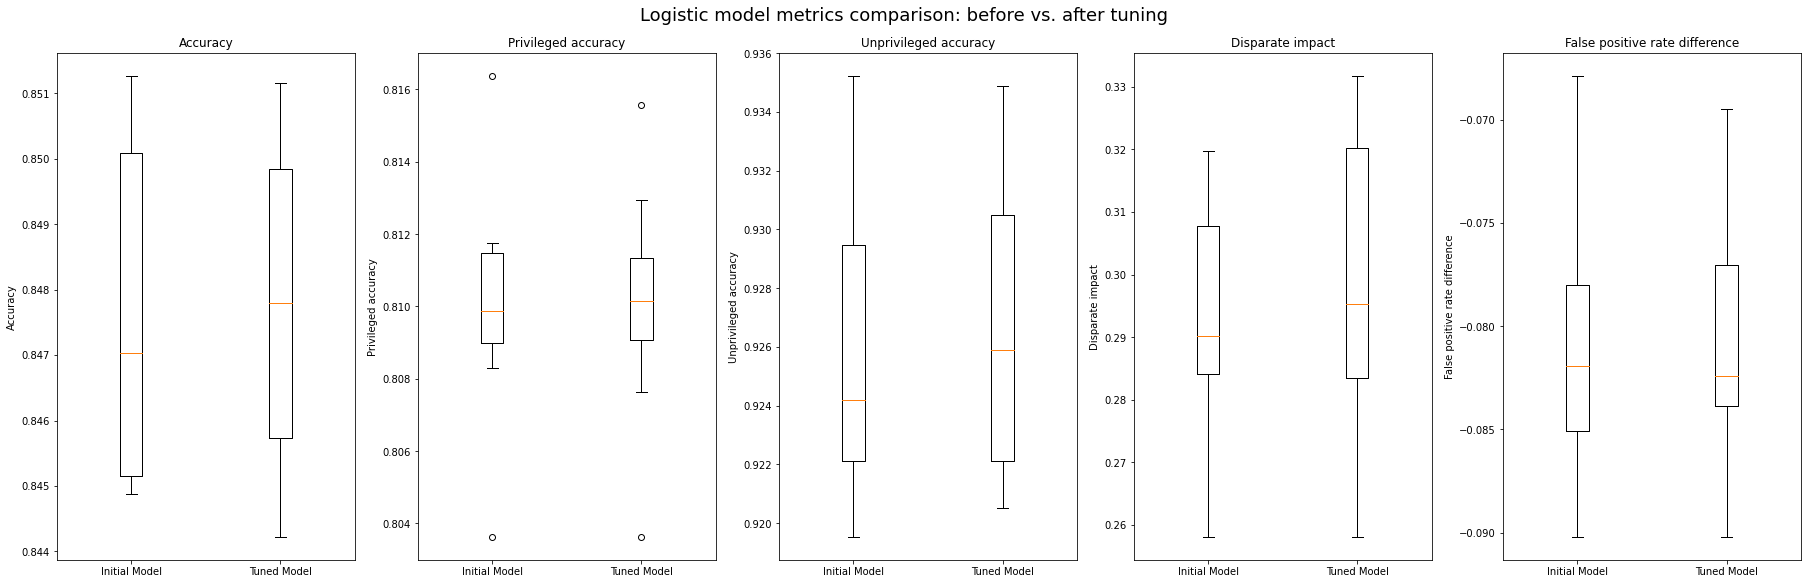

In [ ]:
# Create subplots to plot logistic model metrics before and after model tuning
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25, 8), constrained_layout=True)
fig.suptitle("Logistic model metrics comparison: before vs. after tuning", fontsize=18)

metrics = ["Accuracy", "Privileged accuracy", "Unprivileged accuracy", "Disparate impact", "False positive rate difference"]

# For each metric in metrics list, plot before vs. after tuning on distinct subplot
for i in range(len(metrics)):
  plot_init_v_tuned_box(init_lr_metrics[metrics[i]], tuned_lr_metrics[metrics[i]], metrics[i], ax[i])

plt.show()

In [ ]:
# Print statistics before vs after tuning
print_statistics("Untuned metrics", init_lr_metrics, "Tuned metrics", tuned_lr_metrics)

Untuned metrics:
                                    Median      Mean     Std Dev  
Accuracy                            0.8470     0.8475     0.0025  
Privileged accuracy                 0.8099     0.8101     0.0031  
Unprivileged accuracy               0.9242     0.9258     0.0049  
Disparate impact                    0.2902     0.2929     0.0190  
False positive rate difference     -0.0819    -0.0814     0.0061  

Tuned metrics:
                                    Median      Mean     Std Dev  
Accuracy                            0.8478     0.8478     0.0024  
Privileged accuracy                 0.8101     0.8101     0.0030  
Unprivileged accuracy               0.9259     0.9264     0.0050  
Disparate impact                    0.2953     0.2987     0.0224  
False positive rate difference     -0.0824    -0.0810     0.0060  


### **Random forest tuning on 10 splits of data**

In [ ]:
def tune_rf_multiple_splits(dataset, splits, n_estimators, max_depth, min_samples_split, max_features):
  """Input: dataset, number of splits to perform, and lists of values for hyperparameters 'penalty' and 'C'
  Returns: two dicts, keyed on evaluation metric names, containing lists of metric values and one list of parameters
  used on each split of the data"""

  # Initialize dicts to store metrics
  init_metrics = {"Accuracy": [], "Privileged accuracy": [], "Unprivileged accuracy": [], "Disparate impact": [], "False positive rate difference": []}
  tuned_metrics = {"Accuracy": [], "Privileged accuracy": [], "Unprivileged accuracy": [], "Disparate impact": [], "False positive rate difference": []}

  # Initialize list to store parameters
  parameters = []
  
  for i in range(splits):

    # Train, validation, test set split
    train_data, test_data = dataset.split([0.7], shuffle=True, seed=i*i)
    val_data, test_data = test_data.split([0.33], shuffle=True)
    
    # Convert to dataframes
    train_df, _ = train_data.convert_to_dataframe()
    val_df, _ = val_data.convert_to_dataframe()
    test_df, _ = test_data.convert_to_dataframe()

    # Split featres & labels
    X_train = train_df.drop('income-per-year', axis=1)
    y_train = train_df['income-per-year']

    X_val = val_df.drop('income-per-year', axis=1)
    y_val = val_df['income-per-year']

    X_test = test_df.drop('income-per-year', axis=1)
    y_test = test_df['income-per-year']

    # Scale data
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Create untuned random forest model
    untuned_model = RandomForestClassifier()
    untuned_model.fit(X_train_scaled, y_train)

    # Store untuned random forest predictions
    untuned_preds_df = test_df.copy()
    untuned_preds_df['income-per-year'] = untuned_model.predict(X_test_scaled)

    # Compute untuned random forest metrics 
    curr_untuned_metrics = compute_evaluation_metrics(test_data, untuned_preds_df)

    # Search for optimal hyperparameters
    tuned_model, best_params = tune_rf_model(X_train_scaled, y_train, X_val_scaled, y_val, n_estimators, max_depth, min_samples_split, max_features, verbose=False)
    parameters.append(best_params)
    
    # Store tuned random forest predictions
    tuned_preds_df = test_df.copy()
    tuned_preds_df['income-per-year'] = tuned_model.predict(X_test_scaled)

    # Compute tuned random forest metrics 
    curr_tuned_metrics = compute_evaluation_metrics(test_data, tuned_preds_df)
      
    # Store metrics
    for key in init_metrics:
      init_metrics[key].append(curr_untuned_metrics[key])
      tuned_metrics[key].append(curr_tuned_metrics[key])
    
    print("Round {} complete.".format(i + 1))

  return init_metrics, tuned_metrics, parameters

In [ ]:
# Random forest model - 10 splits & metrics comparison

num_estimators = [100, 200, 500]
max_depth = [10, 50, None]
min_samples_split = [2, 5, 10]
max_features = ['auto', 'log2']

init_rf_metrics, tuned_rf_metrics, rf_parameters = tune_rf_multiple_splits(adult_dataset, 10, num_estimators, max_depth, min_samples_split, max_features)

Round 1 complete.
Round 2 complete.
Round 3 complete.
Round 4 complete.
Round 5 complete.
Round 6 complete.
Round 7 complete.
Round 8 complete.
Round 9 complete.
Round 10 complete.


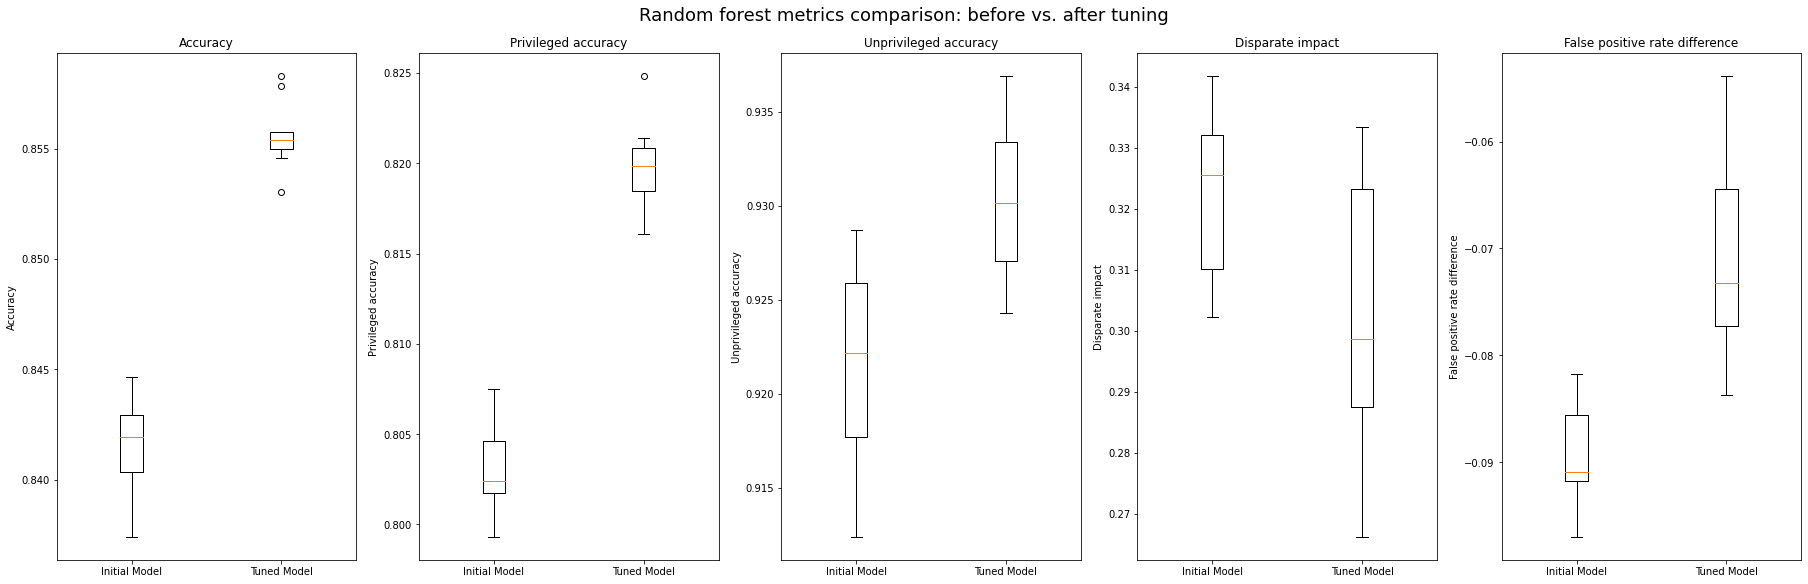

In [ ]:
# Create subplots to plot random forest metrics before vs. after model tuning
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25, 8), constrained_layout=True)
fig.suptitle("Random forest metrics comparison: before vs. after tuning", fontsize=18)

metrics = ["Accuracy", "Privileged accuracy", "Unprivileged accuracy", "Disparate impact", "False positive rate difference"]

# For each metric in metrics list, plot before vs. after tuning on distinct subplot  
for i in range(len(metrics)):
  plot_init_v_tuned_box(init_rf_metrics[metrics[i]], tuned_rf_metrics[metrics[i]], metrics[i], ax[i])

plt.show()

In [ ]:
# Print statistics before vs after tuning
print_statistics("Untuned metrics", init_rf_metrics, "Tuned metrics", tuned_rf_metrics)

Untuned metrics:
                                    Median      Mean     Std Dev  
Accuracy                            0.8419     0.8414     0.0023  
Privileged accuracy                 0.8024     0.8030     0.0024  
Unprivileged accuracy               0.9221     0.9215     0.0054  
Disparate impact                    0.3256     0.3223     0.0132  
False positive rate difference     -0.0909    -0.0898     0.0049  

Tuned metrics:
                                    Median      Mean     Std Dev  
Accuracy                            0.8554     0.8556     0.0015  
Privileged accuracy                 0.8199     0.8198     0.0023  
Unprivileged accuracy               0.9302     0.9303     0.0038  
Disparate impact                    0.2987     0.3018     0.0230  
False positive rate difference     -0.0732    -0.0705     0.0096  


# Problem 2, Part (c) 
### **Disparate Impact Pre-Processing intervention**

In [ ]:
def plot_repair_levels(repair_levels, metric_vals, metric_name, ax, x_label='Repair level'):
  '''Takes a list of repair levels and another list of values of a metric and
  creates a line plot showing how the metric changed for different values of repair level'''

  # Plot the metrics
  for vals in metric_vals:
    ax.plot(repair_levels, vals, linewidth=3, label=metric_name)

  # Create labels, etc. 
  ax.set_xlabel(x_label)
  ax.set_ylabel(metric_name)
  ax.set_title(metric_name)

In [ ]:
# Re-open adult dataset with only continuous variables
adult_dataset = AdultDataset(protected_attribute_names=['sex'],
    privileged_classes=[['Male']], categorical_features=[],
    features_to_keep=['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'])

In [ ]:
def remove_lr_disparate_impact(dataset, repair_levels, parameters, splits):
  """Input: dataset, list of optimized hyperparameters, and number of splits to perform
  Returns: Evaluation metrics after applying DisparateImpactRemover and making predictions with logistic regression model"""

  # Initialize dicts to store metrics
  metrics = []
  for i in range(splits):
    metrics.append({"Accuracy": [],
                    "Privileged accuracy": [],
                    "Unprivileged accuracy": [],
                    "Disparate impact": [],
                    "False positive rate difference": []
                    })

  for i in range(splits):

    # Train, validation, test set split
    train_data, test_data = dataset.split([0.7], shuffle=True, seed=(i*i))
    val_data, test_data = test_data.split([0.33], shuffle=True)

    # Scale features
    scaler = MinMaxScaler()
    train_data.features = scaler.fit_transform(train_data.features)
    test_data.features = scaler.transform(test_data.features)

    # Repair disparate impact & train models
    for level in repair_levels:

      # Apply disparate impact remover to train data
      disparate_impact_remover = DisparateImpactRemover(repair_level=level, sensitive_attribute='sex')
      train_data_repaired = disparate_impact_remover.fit_transform(train_data)
      test_data_repaired = disparate_impact_remover.fit_transform(test_data)

      # Convert to dataframes
      train_df, _ = train_data_repaired.convert_to_dataframe()
      test_df, _ = test_data_repaired.convert_to_dataframe()

      # Split features & labels
      X_train = train_df.drop(['sex', 'income-per-year'], axis=1)
      y_train = train_df['income-per-year']

      X_test = test_df.drop(['sex', 'income-per-year'], axis=1)
      y_test = test_df['income-per-year']

      # Train logistic regression model with optimal hyperparameters from 2b
      lr_model = LogisticRegression(penalty=parameters[i]['penalty'], C=parameters[i]['C'], solver='liblinear')
      lr_model.fit(X_train, y_train)

      # Store tuned logistic model predictions
      lr_preds_df = test_df.copy()
      lr_preds_df['income-per-year'] = lr_model.predict(X_test)

      # Compute tuned logstic model metrics 
      lr_metrics = compute_evaluation_metrics(test_data_repaired, lr_preds_df)

      # Store metrics
      for key in lr_metrics:
        metrics[i][key].append(lr_metrics[key])

    print("Round {} complete.".format(i + 1))

  return metrics

In [ ]:
# Create list of repair levels for DisparateImpactRemover
repair_levels = [0.2, 0.4, 0.6, 0.8, 1.0]

# Apply DisparateImpactRemover & compute evaluation metrics on 10 splits of data
repaired_lr_metrics = remove_lr_disparate_impact(adult_dataset, lr_parameters, 10)

Round 1 complete.
Round 2 complete.
Round 3 complete.
Round 4 complete.
Round 5 complete.
Round 6 complete.
Round 7 complete.
Round 8 complete.
Round 9 complete.
Round 10 complete.


In [ ]:
def plot_all_splits(repaired_metrics, repair_levels):
  # Create subplots to plot evaluation metrics at various repair levels
  fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25, 8), constrained_layout=True)

  # Initialize lists for each metric
  repd_acc = []
  repd_priv_acc = []
  repd_unpriv_acc = []
  repd_di = []
  repd_fpr_diff = []

  # For each repaired metric list, create sublists representing each split of the data
  for i in range(len(repaired_metrics)):
    repd_acc.append(repaired_metrics[i]["Accuracy"])
    repd_priv_acc.append(repaired_metrics[i]["Privileged accuracy"])
    repd_unpriv_acc.append(repaired_metrics[i]["Unprivileged accuracy"])
    repd_di.append(repaired_metrics[i]["Disparate impact"])
    repd_fpr_diff.append(repaired_metrics[i]["False positive rate difference"])

  # Plot metrics such that each line represents one split of the data
  plot_repair_levels(repair_levels, repd_acc, "Accuracy", ax[0])
  plot_repair_levels(repair_levels, repd_priv_acc, "Privileged Accuracy", ax[1])
  plot_repair_levels(repair_levels, repd_unpriv_acc, "Unprivileged Accuracy", ax[2])
  plot_repair_levels(repair_levels, repd_di, "Disparate Impact", ax[3])
  plot_repair_levels(repair_levels, repd_fpr_diff, "False Positive Rate Difference", ax[4])

  plt.show()

  return repd_acc, repd_priv_acc, repd_unpriv_acc, repd_di, repd_fpr_diff

In [ ]:
def plot_avg_splits(repd_acc, repd_priv_acc, repd_unpriv_acc, repd_di, repd_fpr_diff, repair_levels):
  # Create subplots to plot average evaluation metrics at various repair levels
  fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25, 8), constrained_layout=True)

  repd_avg_acc = [[0 for i in range(5)]]
  repd_priv_avg_acc = [[0 for i in range(5)]]
  repd_unpriv_avg_acc = [[0 for i in range(5)]]
  repd_avg_di = [[0 for i in range(5)]]
  repd_fpr_avg_diff = [[0 for i in range(5)]]

  # Compute average values of repaired metrics
  for i in range(len(repd_acc)):
    for j in range(len(repd_acc[i])):
      repd_avg_acc[0][j] += repd_acc[i][j]
      repd_priv_avg_acc[0][j] += repd_priv_acc[i][j]
      repd_unpriv_avg_acc[0][j] += repd_unpriv_acc[i][j]
      repd_avg_di[0][j] += repd_di[i][j]
      repd_fpr_avg_diff[0][j] += repd_fpr_diff[i][j]

  for j in range(len(repd_avg_acc[0])):
    repd_avg_acc[0][j] /= 10
    repd_priv_avg_acc[0][j] /= 10
    repd_unpriv_avg_acc[0][j] /= 10
    repd_avg_di[0][j] /= 10
    repd_fpr_avg_diff[0][j] /= 10

  # Plot average metrics
  plot_repair_levels(repair_levels, repd_avg_acc, "Accuracy", ax[0])
  plot_repair_levels(repair_levels, repd_priv_avg_acc, "Privileged Accuracy", ax[1])
  plot_repair_levels(repair_levels, repd_unpriv_avg_acc, "Unprivileged Accuracy", ax[2])
  plot_repair_levels(repair_levels, repd_avg_di, "Disparate Impact", ax[3])
  plot_repair_levels(repair_levels, repd_fpr_avg_diff, "False Positive Rate Difference", ax[4])

  plt.show()

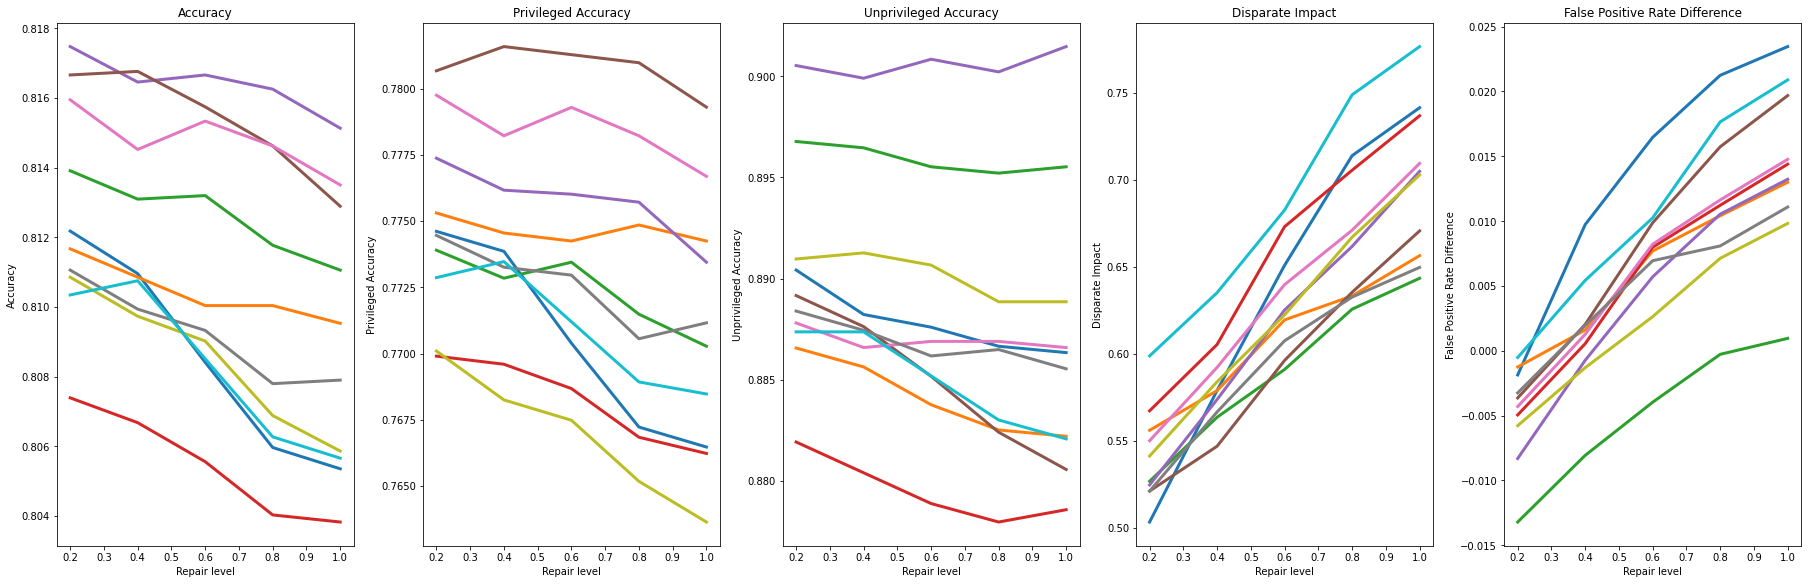

In [ ]:
# Plot repaired evaluation metrics for each split of data
repd_lr_acc, repd_lr_priv_acc, repd_lr_unpriv_acc, repd_lr_di, repd_lr_fpr_diff = plot_all_splits(repaired_lr_metrics, repair_levels)

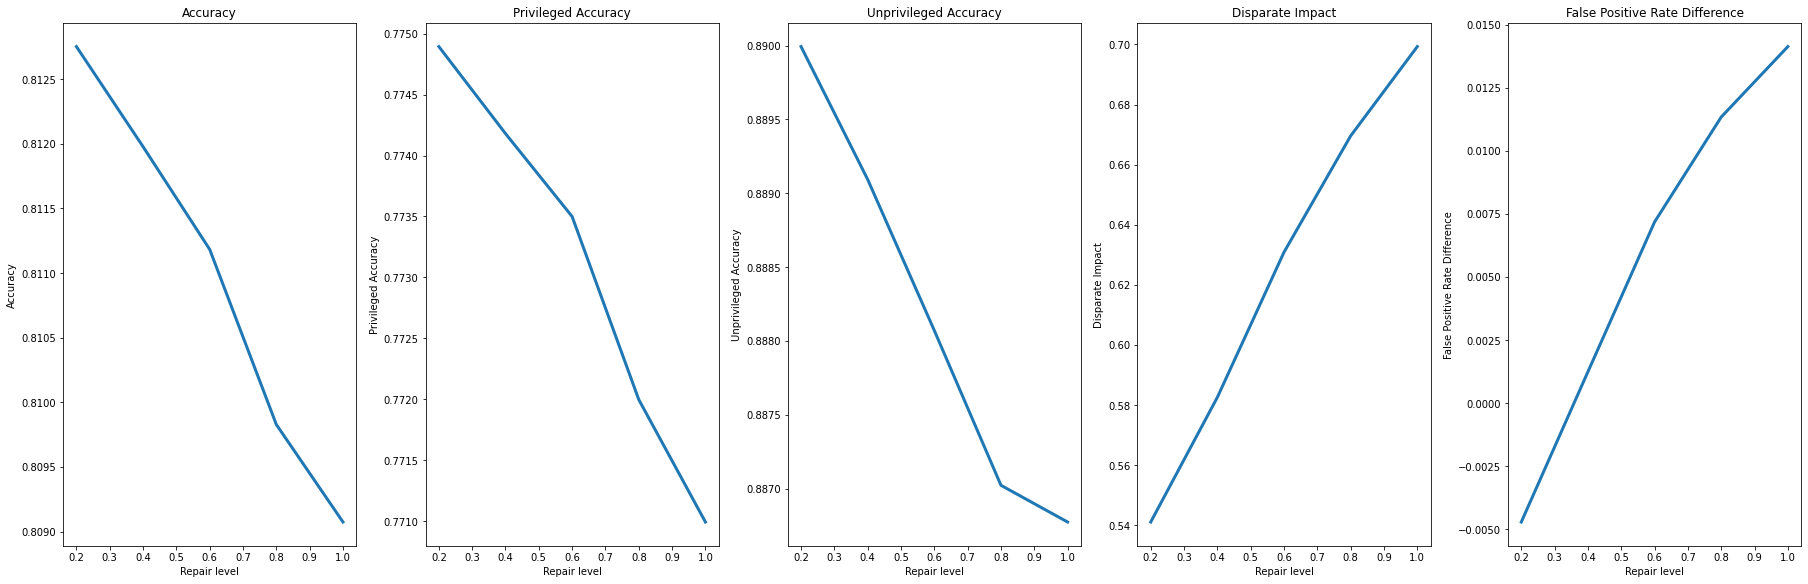

In [ ]:
# Plot average metrics for each repair level
plot_avg_splits(repd_lr_acc, repd_lr_priv_acc, repd_lr_unpriv_acc, repd_lr_di, repd_lr_fpr_diff, repair_levels)

In [ ]:
# Group by repair level for statistical analysis
repair_levels = [0.2, 0.4, 0.6, 0.8, 1.0]

lr_rep_lvl_metrics = {"Accuracy": {},
                      "Privileged accuracy": {},
                      "Unprivileged accuracy": {},
                      "Disparate impact": {},
                      "False positive rate difference": {}
                      }

# For each evaluation metric, initialize list for each repair level
for key in lr_rep_lvl_metrics:
  for i in repair_levels:
    lr_rep_lvl_metrics[key][i] = []

# Group evaluation metrics by repair level
for split in range(len(repaired_lr_metrics)):
  for key in repaired_lr_metrics[split]:
    for i in range(len(repair_levels)):
      lr_rep_lvl_metrics[key][repair_levels[i]].append(repaired_lr_metrics[split][key][i])

In [ ]:
# Print statistics at repair level = 0.2
print("Metrics at repair level = 0.2:")
print("{blank: <33} {med: ^10} {mean: ^10} {std: ^10}".format(blank="", med="Median", mean="Mean", std="Std Dev"))
for key in lr_rep_lvl_metrics:
  print("{key: <33} {med: ^10} {mean: ^10} {std: ^10}".format(key=key, med="{:.4f}".format(np.median(lr_rep_lvl_metrics[key][0.2])), 
                                                              mean="{:.4f}".format(np.mean(lr_rep_lvl_metrics[key][0.2])), std="{:.4f}".format(np.std(lr_rep_lvl_metrics[key][0.2]))))

# Print statistics at repair level = 0.6
print("\nMetrics at repair level = 0.6:")
print("{blank: <33} {med: ^10} {mean: ^10} {std: ^10}".format(blank="", med="Median", mean="Mean", std="Std Dev"))
for key in lr_rep_lvl_metrics:
  print("{key: <33} {med: ^10} {mean: ^10} {std: ^10}".format(key=key, med="{:.4f}".format(np.median(lr_rep_lvl_metrics[key][0.6])), 
                                                              mean="{:.4f}".format(np.mean(lr_rep_lvl_metrics[key][0.6])), std="{:.4f}".format(np.std(lr_rep_lvl_metrics[key][0.6]))))

# Print statistics at repair level = 1.0
print("\nMetrics at repair level = 1.0:")
print("{blank: <33} {med: ^10} {mean: ^10} {std: ^10}".format(blank="", med="Median", mean="Mean", std="Std Dev"))
for key in lr_rep_lvl_metrics:
  print("{key: <33} {med: ^10} {mean: ^10} {std: ^10}".format(key=key, med="{:.4f}".format(np.median(lr_rep_lvl_metrics[key][1.0])), 
                                                              mean="{:.4f}".format(np.mean(lr_rep_lvl_metrics[key][1.0])), std="{:.4f}".format(np.std(lr_rep_lvl_metrics[key][1.0]))))


Metrics at repair level = 0.2:
                                    Median      Mean     Std Dev  
Accuracy                            0.8119     0.8128     0.0030  
Privileged accuracy                 0.7745     0.7749     0.0034  
Unprivileged accuracy               0.8888     0.8900     0.0050  
Disparate impact                    0.5341     0.5411     0.0265  
False positive rate difference     -0.0040    -0.0047     0.0036  

Metrics at repair level = 0.6:
                                    Median      Mean     Std Dev  
Accuracy                            0.8097     0.8112     0.0036  
Privileged accuracy                 0.7732     0.7735     0.0042  
Unprivileged accuracy               0.8865     0.8881     0.0059  
Disparate impact                    0.6238     0.6309     0.0292  
False positive rate difference      0.0078     0.0072     0.0050  

Metrics at repair level = 1.0:
                                    Median      Mean     Std Dev  
Accuracy                          

In [ ]:
def remove_rf_disparate_impact(dataset, repair_levels, parameters, splits):
  """Input: dataset, list of optimized hyperparameters, and number of splits to perform
  Returns: Evaluation metrics after applying DisparateImpactRemover and making predictions with random forest model"""

  # Initialize dicts to store metrics
  metrics = []
  for i in range(splits):
    metrics.append({"Accuracy": [],
                    "Privileged accuracy": [],
                    "Unprivileged accuracy": [],
                    "Disparate impact": [],
                    "False positive rate difference": []
                    })

  for i in range(splits):

    # Train, validation, & test set splits
    train_data, test_data = dataset.split([0.7], shuffle=True, seed=(i*i))
    val_data, test_data = train_data.split([0.33], shuffle=True)

    # Scale features
    scaler = MinMaxScaler()
    train_data.features = scaler.fit_transform(train_data.features)
    test_data.features= scaler.transform(test_data.features)

    # Repair disparate impact & train models
    for level in repair_levels:

      # Apply disparate impact remover to train data
      disparate_impact_remover = DisparateImpactRemover(repair_level=level, sensitive_attribute='sex')
      train_data_repaired = disparate_impact_remover.fit_transform(train_data)
      test_data_repaired = disparate_impact_remover.fit_transform(test_data)

      # Convert to dataframes
      train_df, _ = train_data_repaired.convert_to_dataframe()
      test_df, _ = test_data_repaired.convert_to_dataframe()

      # Split into features & labels
      X_train = train_df.drop(['sex', 'income-per-year'], axis=1)
      y_train = train_df['income-per-year']

      X_test = test_df.drop(['sex', 'income-per-year'], axis=1)
      y_test = test_df['income-per-year']

      # Train random forest mdoel with optimal hyperparameters
      rf_model = RandomForestClassifier(n_estimators=parameters[i]['n_estimators'], max_depth=parameters[i]['max_depth'], 
                                        min_samples_split=parameters[i]['min_samples_split'], max_features=parameters[i]['max_features'])
      rf_model.fit(X_train, y_train)

      # Store tuned logistic model predictions
      rf_preds_df = test_df.copy()
      rf_preds_df['income-per-year'] = rf_model.predict(X_test)

      # Compute tuned logstic model metrics 
      rf_metrics = compute_evaluation_metrics(test_data_repaired, rf_preds_df)
    
      # Store metrics
      for key in rf_metrics:
        metrics[i][key].append(rf_metrics[key])
      
    print("Round {} complete.".format(i + 1))
    
  return metrics

In [ ]:
# Create list of repair levels for DisparateImpactRemover
repair_levels = [0.2, 0.4, 0.6, 0.8, 1.0]

# Apply DisparateImpactRemover & compute evaluation metrics on 10 splits of data
repaired_rf_metrics = remove_rf_disparate_impact(adult_dataset, repair_levels, rf_parameters, 10)

Round 1 complete.
Round 2 complete.
Round 3 complete.
Round 4 complete.
Round 5 complete.
Round 6 complete.
Round 7 complete.
Round 8 complete.
Round 9 complete.
Round 10 complete.


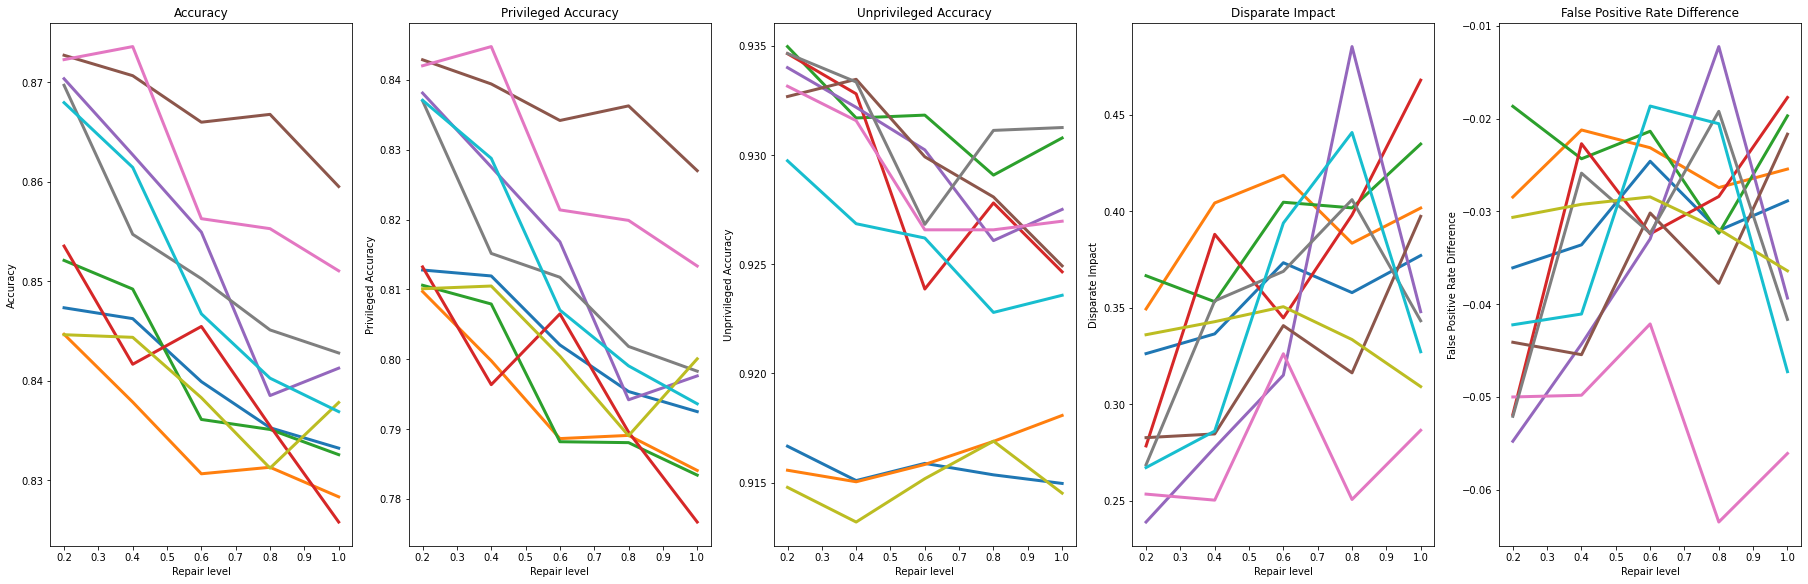

In [ ]:
# Plot rf evaluation metrics with disparate impact remover
repd_rf_acc, repd_rf_priv_acc, repd_rf_unpriv_acc, repd_rf_di, repd_rf_fpr_diff = plot_all_splits(repaired_rf_metrics, repair_levels)

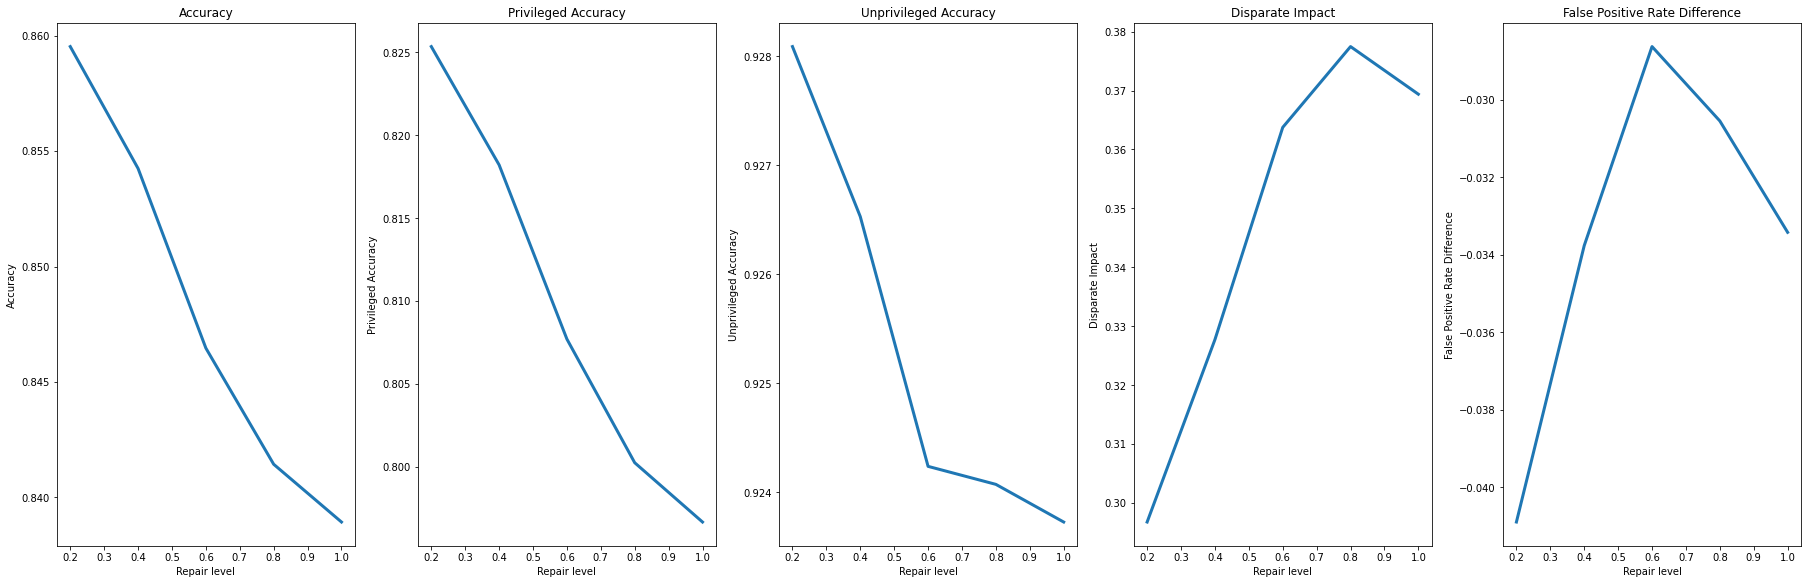

In [ ]:
# Plot average metrics for each repair level
plot_avg_splits(repd_rf_acc, repd_rf_priv_acc, repd_rf_unpriv_acc, repd_rf_di, repd_rf_fpr_diff, repair_levels)

In [ ]:
# Group by repair level for statistical analysis
repair_levels = [0.2, 0.4, 0.6, 0.8, 1.0]

rf_rep_lvl_metrics = {"Accuracy": {},
                      "Privileged accuracy": {},
                      "Unprivileged accuracy": {},
                      "Disparate impact": {},
                      "False positive rate difference": {}
                      }

# For each evaluation metric, initialize list for each repair level
for key in rf_rep_lvl_metrics:
  for i in repair_levels:
    rf_rep_lvl_metrics[key][i] = []

# Group evaluation metrics by repair level
for split in range(len(repaired_rf_metrics)):
  for key in repaired_rf_metrics[split]:
    for i in range(len(repair_levels)):
      rf_rep_lvl_metrics[key][repair_levels[i]].append(repaired_rf_metrics[split][key][i])

In [ ]:
# Print statistics at repair level = 0.2
print("Metrics at repair level = 0.2:")
print("{blank: <33} {med: ^10} {mean: ^10} {std: ^10}".format(blank="", med="Median", mean="Mean", std="Std Dev"))
for key in lr_rep_lvl_metrics:
  print("{key: <33} {med: ^10} {mean: ^10} {std: ^10}".format(key=key, med="{:.4f}".format(np.median(rf_rep_lvl_metrics[key][0.2])), 
                                                              mean="{:.4f}".format(np.mean(rf_rep_lvl_metrics[key][0.2])), std="{:.4f}".format(np.std(rf_rep_lvl_metrics[key][0.2]))))

# Print statistics at repair level = 0.6
print("\nMetrics at repair level = 0.6:")
print("{blank: <33} {med: ^10} {mean: ^10} {std: ^10}".format(blank="", med="Median", mean="Mean", std="Std Dev"))
for key in lr_rep_lvl_metrics:
  print("{key: <33} {med: ^10} {mean: ^10} {std: ^10}".format(key=key, med="{:.4f}".format(np.median(rf_rep_lvl_metrics[key][0.6])), 
                                                              mean="{:.4f}".format(np.mean(rf_rep_lvl_metrics[key][0.6])), std="{:.4f}".format(np.std(rf_rep_lvl_metrics[key][0.6]))))

# Print statistics at repair level = 1.0
print("\nMetrics at repair level = 1.0:")
print("{blank: <33} {med: ^10} {mean: ^10} {std: ^10}".format(blank="", med="Median", mean="Mean", std="Std Dev"))
for key in lr_rep_lvl_metrics:
  print("{key: <33} {med: ^10} {mean: ^10} {std: ^10}".format(key=key, med="{:.4f}".format(np.median(rf_rep_lvl_metrics[key][1.0])), 
                                                              mean="{:.4f}".format(np.mean(rf_rep_lvl_metrics[key][1.0])), std="{:.4f}".format(np.std(rf_rep_lvl_metrics[key][1.0]))))

Metrics at repair level = 0.2:
                                    Median      Mean     Std Dev  
Accuracy                            0.8607     0.8595     0.0114  
Privileged accuracy                 0.8251     0.8254     0.0142  
Unprivileged accuracy               0.9329     0.9281     0.0083  
Disparate impact                    0.2805     0.2968     0.0418  
False positive rate difference     -0.0432    -0.0409     0.0114  

Metrics at repair level = 0.6:
                                    Median      Mean     Std Dev  
Accuracy                            0.8461     0.8465     0.0102  
Privileged accuracy                 0.8068     0.8077     0.0135  
Unprivileged accuracy               0.9264     0.9242     0.0060  
Disparate impact                    0.3598     0.3637     0.0325  
False positive rate difference     -0.0293    -0.0286     0.0066  

Metrics at repair level = 1.0:
                                    Median      Mean     Std Dev  
Accuracy                          

# Problem 2, Part (d) 
### **Reject Option Post-Processing intervention**

In [ ]:
def compute_ROC_metrics(orig_test_dataset, preds_test_dataset):
  """Input: original test dataset with ground truth labels and ROC predictions dataset
  Returns: dict with evaluation metrics"""
  
  # Specify privileged and unprivileged groups
  privileged_groups = [{'sex': 1.0}]
  unprivileged_groups = [{'sex': 0.0}]

  # Convert datasets to binary label & classification metric objects
  preds_binary_metric = BinaryLabelDatasetMetric(preds_test_dataset, 
                                                 unprivileged_groups=unprivileged_groups, 
                                                 privileged_groups=privileged_groups)
  
  orig_vs_preds_metric = ClassificationMetric(orig_test_dataset, preds_test_dataset,
                                              unprivileged_groups=unprivileged_groups,
                                              privileged_groups=privileged_groups)
  
  # Print evaluation metrics
  accuracy = orig_vs_preds_metric.accuracy()
  priv_accuracy = orig_vs_preds_metric.accuracy(privileged=True)
  unpriv_accuracy = orig_vs_preds_metric.accuracy(privileged=False)
  disp_impact = preds_binary_metric.disparate_impact()
  false_pos_dif = orig_vs_preds_metric.false_positive_rate_difference()

  return {"Accuracy": accuracy, "Privileged accuracy": priv_accuracy, "Unprivileged accuracy": unpriv_accuracy, "Disparate impact": disp_impact, "False positive rate difference": false_pos_dif}

In [ ]:
def lr_model_ROC(dataset, parameters, splits):
  """Input: dataset, list of optimized hyperparameters, and number of splits to perform
  Returns: Evaluation metrics after applying RejectOptionClassification and making predictions with logistic regression model"""

  # Initialize dict to store metrics
  metrics = {"Accuracy": [], "Privileged accuracy": [], "Unprivileged accuracy": [], "Disparate impact": [], "False positive rate difference": []}

  for i in range(splits):

    # Train, validation, test set splits
    train_data, test_data = dataset.split([0.7], shuffle=True, seed=i*i)
    val_data, test_data = test_data.split([0.33], shuffle=True)

    # Scale data and split features and labels
    scaler = MinMaxScaler()

    X_train = scaler.fit_transform(train_data.features)
    y_train = train_data.labels.ravel()

    X_val = scaler.transform(val_data.features)
    y_val = val_data.labels

    X_test = scaler.transform(test_data.features)
    y_test = test_data.labels

    # Train logistic regression model
    lr_model = LogisticRegression(penalty=parameters[i]["penalty"], C=parameters[i]['C'], solver='liblinear')
    lr_model.fit(X_train, y_train)

    # Get validation set scores to train ROC 
    val_preds = val_data.copy(deepcopy=True)
    val_preds.scores = lr_model.predict_proba(X_val)[:, 1].reshape(-1,1)

    # Fit ROC using validation set scores
    ROC = RejectOptionClassification(unprivileged_groups=[{'sex': 0}], 
                                    privileged_groups=[{'sex': 1}])
    ROC = ROC.fit(val_data, val_preds)

    # Print ROC parameters
    print("Optimal classification threshold = %.4f" % ROC.classification_threshold)
    print("Optimal ROC margin = %.4f" % ROC.ROC_margin)

    # Get test set scores for ROC predictions
    test_preds = test_data.copy(deepcopy=True)
    test_preds.scores = lr_model.predict_proba(X_test)[:, 1].reshape(-1, 1)

    # Compute ROC predictions
    ROC_test_preds = ROC.predict(test_preds)

    # Compute evalution metrics on ROC predictions
    test_metrics = compute_ROC_metrics(test_data, ROC_test_preds)

    # Store ROC evaluation metrics
    for key in metrics:
      metrics[key].append(test_metrics[key])
    
    print("Round {} complete.\n".format(i + 1))

  return metrics

In [ ]:
lr_ROC_metrics = lr_model_ROC(adult_dataset, lr_parameters, 10)

Optimal classification threshold = 0.1882
Optimal ROC margin = 0.0960
Round 1 complete.

Optimal classification threshold = 0.1783
Optimal ROC margin = 0.0946
Round 2 complete.

Optimal classification threshold = 0.1981
Optimal ROC margin = 0.1091
Round 3 complete.

Optimal classification threshold = 0.2278
Optimal ROC margin = 0.1209
Round 4 complete.

Optimal classification threshold = 0.1981
Optimal ROC margin = 0.1051
Round 5 complete.

Optimal classification threshold = 0.2179
Optimal ROC margin = 0.1156
Round 6 complete.

Optimal classification threshold = 0.2080
Optimal ROC margin = 0.1061
Round 7 complete.

Optimal classification threshold = 0.1981
Optimal ROC margin = 0.1011
Round 8 complete.

Optimal classification threshold = 0.2179
Optimal ROC margin = 0.1112
Round 9 complete.

Optimal classification threshold = 0.2179
Optimal ROC margin = 0.1112
Round 10 complete.



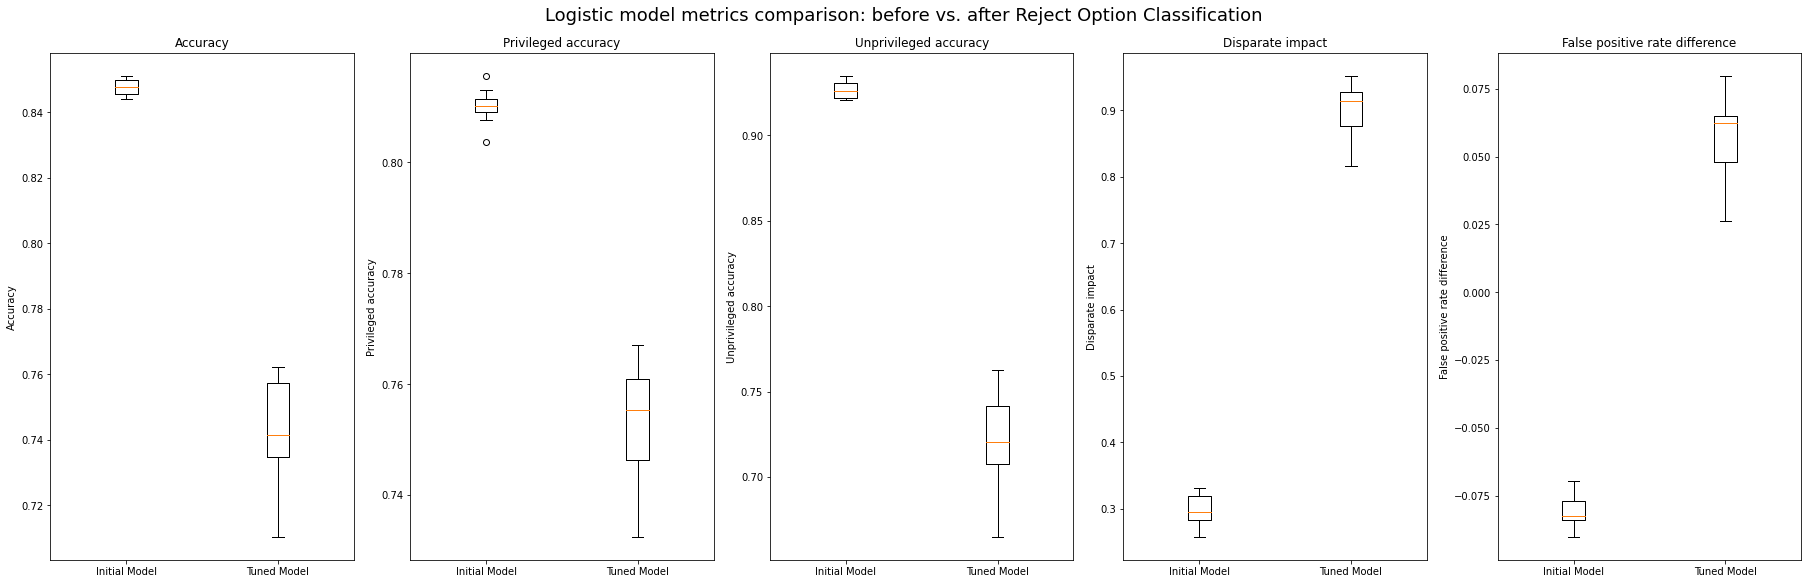

In [ ]:
# Create subplots to plot logistic model metrics before and after ROC
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25, 8), constrained_layout=True)
fig.suptitle("Logistic model metrics comparison: before vs. after Reject Option Classification", fontsize=18)

metrics = ["Accuracy", "Privileged accuracy", "Unprivileged accuracy", "Disparate impact", "False positive rate difference"]

# For each metric in metrics list, plot before vs. after tuning on distinct subplot
for i in range(len(metrics)):
  plot_init_v_tuned_box(tuned_lr_metrics[metrics[i]], lr_ROC_metrics[metrics[i]], metrics[i], ax[i])

plt.show()

In [ ]:
# Print statistics before vs after ROC
print_statistics("Pre-ROC metrics", tuned_lr_metrics, "Post-ROC metrics", lr_ROC_metrics)

Pre-ROC metrics:
                                    Median      Mean     Std Dev  
Accuracy                            0.8478     0.8478     0.0024  
Privileged accuracy                 0.8101     0.8101     0.0030  
Unprivileged accuracy               0.9259     0.9264     0.0050  
Disparate impact                    0.2953     0.2987     0.0224  
False positive rate difference     -0.0824    -0.0810     0.0060  

Post-ROC metrics:
                                    Median      Mean     Std Dev  
Accuracy                            0.7414     0.7429     0.0151  
Privileged accuracy                 0.7554     0.7529     0.0103  
Unprivileged accuracy               0.7206     0.7225     0.0272  
Disparate impact                    0.9139     0.9017     0.0414  
False positive rate difference      0.0624     0.0579     0.0158  


In [ ]:
def rf_model_ROC(dataset, parameters, splits):
  """Input: dataset, list of optimized hyperparameters, and number of splits to perform
  Returns: Evaluation metrics after applying RejectOptionClassification and making predictions with random forest model"""

  # Initialize dict to store metrics
  metrics = {"Accuracy": [], "Privileged accuracy": [], "Unprivileged accuracy": [], "Disparate impact": [], "False positive rate difference": []}

  for i in range(splits):

    # Train, validation, test set splits
    train_data, test_data = dataset.split([0.7], shuffle=True, seed=i*i)
    val_data, test_data = test_data.split([0.33], shuffle=True)

    # Scale data and split features and labels
    scaler = MinMaxScaler()

    X_train = scaler.fit_transform(train_data.features)
    y_train = train_data.labels.ravel()

    X_val = scaler.transform(val_data.features)
    y_val = val_data.labels

    X_test = scaler.transform(test_data.features)
    y_test = test_data.labels

    # Train random forest model
    rf_model = RandomForestClassifier(n_estimators=parameters[i]['n_estimators'], max_depth=parameters[i]['max_depth'], 
                                      min_samples_split=parameters[i]['min_samples_split'], max_features=parameters[i]['max_features'])
    rf_model.fit(X_train, y_train)

    # Get validation set scores to train ROC 
    val_preds = val_data.copy(deepcopy=True)
    val_preds.scores = rf_model.predict_proba(X_val)[:, 1].reshape(-1,1)

    # Fit ROC using validation set scores
    ROC = RejectOptionClassification(unprivileged_groups=[{'sex': 0}], 
                                    privileged_groups=[{'sex': 1}])
    ROC = ROC.fit(val_data, val_preds)

    # Print ROC parameters
    print("Optimal classification threshold = %.4f" % ROC.classification_threshold)
    print("Optimal ROC margin = %.4f" % ROC.ROC_margin)

    # Get test set scores for ROC predictions
    test_preds = test_data.copy(deepcopy=True)
    test_preds.scores = rf_model.predict_proba(X_test)[:, 1].reshape(-1, 1)

    # Compute ROC predictions
    ROC_test_preds = ROC.predict(test_preds)

    # Compute evalution metrics on ROC predictions
    test_metrics = compute_ROC_metrics(test_data, ROC_test_preds)

    # Store ROC evaluation metrics
    for key in metrics:
      metrics[key].append(test_metrics[key])
    
    print("Round {} complete.\n".format(i + 1))

  return metrics

In [ ]:
rf_ROC_metrics = rf_model_ROC(adult_dataset, rf_parameters, 10)

Optimal classification threshold = 0.1981
Optimal ROC margin = 0.1051
Round 1 complete.

Optimal classification threshold = 0.2179
Optimal ROC margin = 0.1156
Round 2 complete.

Optimal classification threshold = 0.2377
Optimal ROC margin = 0.1310
Round 3 complete.

Optimal classification threshold = 0.2278
Optimal ROC margin = 0.1255
Round 4 complete.

Optimal classification threshold = 0.1882
Optimal ROC margin = 0.1037
Round 5 complete.

Optimal classification threshold = 0.2377
Optimal ROC margin = 0.1261
Round 6 complete.

Optimal classification threshold = 0.2179
Optimal ROC margin = 0.1245
Round 7 complete.

Optimal classification threshold = 0.2278
Optimal ROC margin = 0.1255
Round 8 complete.

Optimal classification threshold = 0.1981
Optimal ROC margin = 0.1091
Round 9 complete.

Optimal classification threshold = 0.2377
Optimal ROC margin = 0.1213
Round 10 complete.



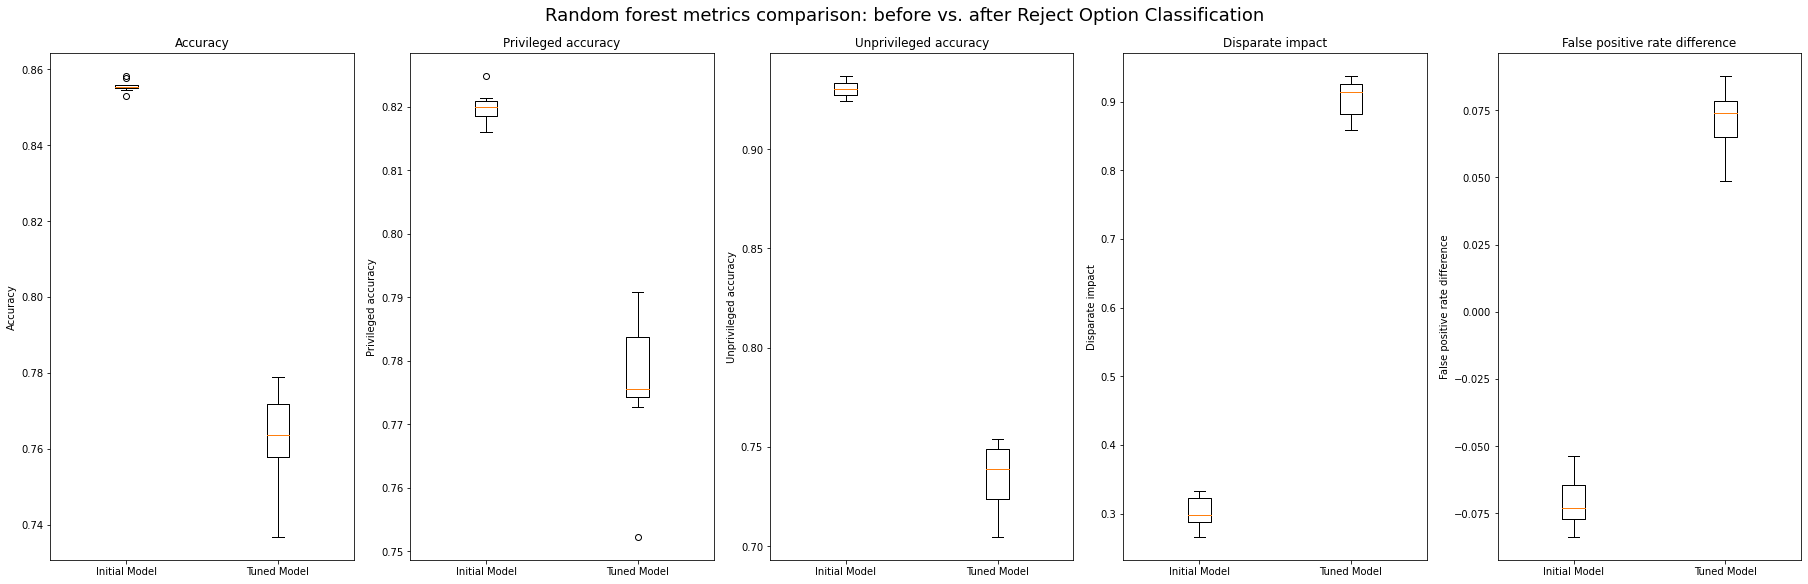

In [ ]:
# Create subplots to plot logistic model metrics before and after ROC
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25, 8), constrained_layout=True)
fig.suptitle("Random forest metrics comparison: before vs. after Reject Option Classification", fontsize=18)

metrics = ["Accuracy", "Privileged accuracy", "Unprivileged accuracy", "Disparate impact", "False positive rate difference"]

# For each metric in metrics list, plot before vs. after tuning on distinct subplot
for i in range(len(metrics)):
  plot_init_v_tuned_box(tuned_rf_metrics[metrics[i]], rf_ROC_metrics[metrics[i]], metrics[i], ax[i])

plt.show()

In [ ]:
# Print statistics before vs after ROC
print_statistics("Pre-ROC metrics", tuned_rf_metrics, "Post-ROC metrics", rf_ROC_metrics)

Pre-ROC metrics:
                                    Median      Mean     Std Dev  
Accuracy                            0.8554     0.8556     0.0015  
Privileged accuracy                 0.8199     0.8198     0.0023  
Unprivileged accuracy               0.9302     0.9303     0.0038  
Disparate impact                    0.2987     0.3018     0.0230  
False positive rate difference     -0.0732    -0.0705     0.0096  

Post-ROC metrics:
                                    Median      Mean     Std Dev  
Accuracy                            0.7635     0.7631     0.0112  
Privileged accuracy                 0.7756     0.7769     0.0100  
Unprivileged accuracy               0.7386     0.7352     0.0155  
Disparate impact                    0.9140     0.9052     0.0266  
False positive rate difference      0.0740     0.0709     0.0115  
